Link:

https://colab.research.google.com/drive/13LDjsFGPeYiyTMnZb1oSzwF2k71Cv754?usp=sharing
https://github.com/nth7396/CNNcancerClassification

# Getting Started

The challenge presented in this competition is the development of an effective algorithm capable of accurately identifying metastatic cancer. The complexity lies in the fact that this algorithm must operate on small, potentially nuanced image patches extracted from larger, detailed digital pathology scans. The ultimate goal is to aid in the timely and precise detection of metastasis, thereby improving cancer diagnosis and treatment planning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping
import tensorflow as tf
import cv2

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henrynguyen888","key":"e93f8d4f8fd84c863c084f8ced73fb86"}'}

In [3]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:52<00:00, 129MB/s]
100% 6.31G/6.31G [00:52<00:00, 130MB/s]


In [5]:
zip_ref = zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /content folder
zip_ref.close()

In [6]:
len(os.listdir('/content/train/'))

220025

There are 220025 photos in the training set.

In [7]:
len(os.listdir('/content/test/'))

57458

There are 57458 photos in the testing set.

In [8]:
# Load your CSV file
df = pd.read_csv('/content/train_labels.csv')

# Check the basic information about your dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [9]:
# Check for missing data
print(df.isnull().sum())

id       0
label    0
dtype: int64


There is no missing data in the training labels.

In [10]:
df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


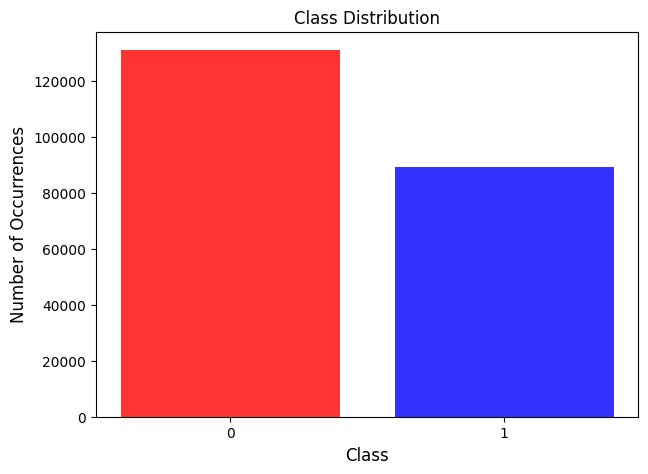

In [12]:
import matplotlib.pyplot as plt

# count the occurrences of each class
class_count = df['label'].value_counts()

plt.figure(figsize=(7, 5))
plt.bar(class_count.index, class_count.values, alpha=0.8, color=['red', 'blue'])
plt.title('Class Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(class_count.index, ['0', '1'])
plt.show()


There is no issue of class imbalance so we can proceed safely.

# Image Inputting

In [14]:
# Convert labels to string
df['label'] = df['label'].astype(str)

# Correctly append the file extension to the image filenames in the dataframe
df['id'] = df['id'].astype(str) + '.tif'  # Only append '.tif' once

In [15]:
# Define your ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalizes the image pixel values to have zero mean and std dev of 1
    shear_range=0.2,       # Randomly applies shearing transformations
    zoom_range=0.2,        # Randomly zooms inside pictures
    horizontal_flip=True)  # Randomly flips the images

# Specify the arguments for flow_from_dataframe()
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')  # set as training data


Found 220025 validated image filenames belonging to 2 classes.


Let's have a look at some examples of the photos for both Label 0 and 1.

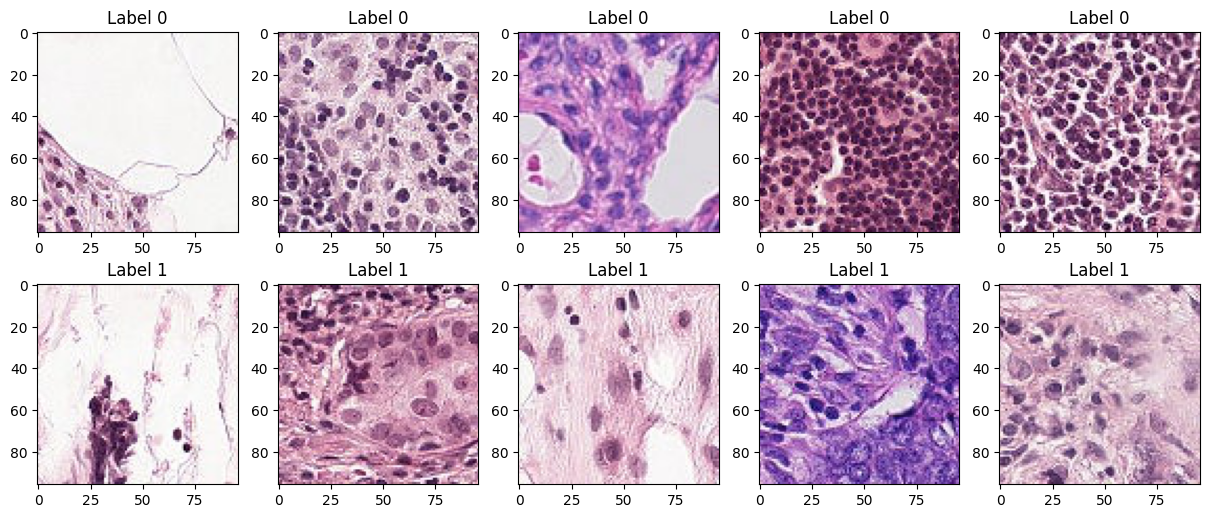

In [18]:
import cv2

# Filter the dataframe for each label
df_label_0 = df[df['label'] == '0']
df_label_1 = df[df['label'] == '1']

# Select the first 5 images from each label
image_filenames_0 = df_label_0['id'].values[:5]
image_filenames_1 = df_label_1['id'].values[:5]

# Define a function to load and plot an image
def plot_image(image_path, ax):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot images with label 0
for i, filename in enumerate(image_filenames_0):
    image_path = '/content/train/' + filename
    plot_image(image_path, axs[0, i])
    axs[0, i].set_title('Label 0')

# Plot images with label 1
for i, filename in enumerate(image_filenames_1):
    image_path = '/content/train/' + filename
    plot_image(image_path, axs[1, i])
    axs[1, i].set_title('Label 1')

plt.show()


# ResNet50

### Model Training

For the first model, I decided to experiment with ResNet50. ResNet, or Residual Network, is a revolutionary architecture in the field of deep learning, extensively used for image classification tasks.

It introduced the concept of "residual learning" or "skip connections," which allows for the training of much deeper networks by skipping certain layers during the forward pass, effectively mitigating the problem of vanishing gradients. The adoption of these unique strategies enables ResNet to successfully handle complex image classification problems and achieve highly accurate results.

In addition to the ResNet base layer, I decided to add 3 Dense layers (relu activated) with accompanying Batch Normalizations and Dropouts. A sigmoid activation layer is added at the end because this is a binary classification task.

In [71]:
from keras.applications import ResNet50
from keras.layers import BatchNormalization

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential()
model.add(resnet_base)
model.add(Flatten())

# Adding more layers
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))  # binary classification

resnet_base.trainable = False  # freeze the convolutional base

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [72]:
# Print a summary of the model
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [73]:
# Fit the model on the training data
model.fit(train_generator, epochs=10)

Epoch 1/10
6876/6876 [==============================] - 582s 84ms/step - loss: 0.5250 - accuracy: 0.7454
Epoch 2/10
6876/6876 [==============================] - 579s 84ms/step - loss: 0.4990 - accuracy: 0.7607
Epoch 3/10
6876/6876 [==============================] - 580s 84ms/step - loss: 0.4912 - accuracy: 0.7657
Epoch 4/10
6876/6876 [==============================] - 578s 84ms/step - loss: 0.4861 - accuracy: 0.7680
Epoch 5/10
6876/6876 [==============================] - 577s 84ms/step - loss: 0.4847 - accuracy: 0.7686
Epoch 6/10
6876/6876 [==============================] - 576s 84ms/step - loss: 0.4815 - accuracy: 0.7712
Epoch 7/10
6876/6876 [==============================] - 579s 84ms/step - loss: 0.4788 - accuracy: 0.7730
Epoch 8/10
6876/6876 [==============================] - 577s 84ms/step - loss: 0.4770 - accuracy: 0.7740
Epoch 9/10
6876/6876 [==============================] - 581s 85ms/step - loss: 0.4776 - accuracy: 0.7736
Epoch 10/10
6876/6876 [==============================] 

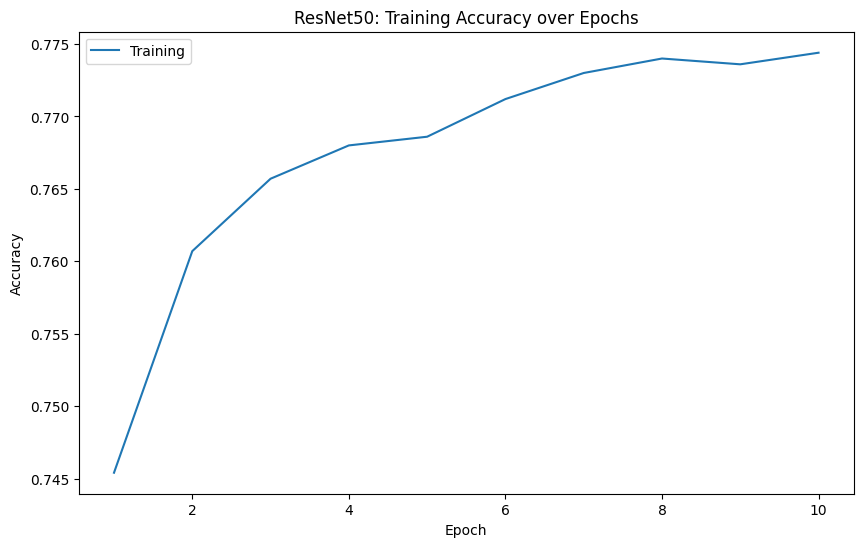

In [20]:
# Training accuracy data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy = [0.7454, 0.7607, 0.7657, 0.7680, 0.7686, 0.7712, 0.7730, 0.7740, 0.7736, 0.7744]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label='Training')

# Add details
plt.title('ResNet50: Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

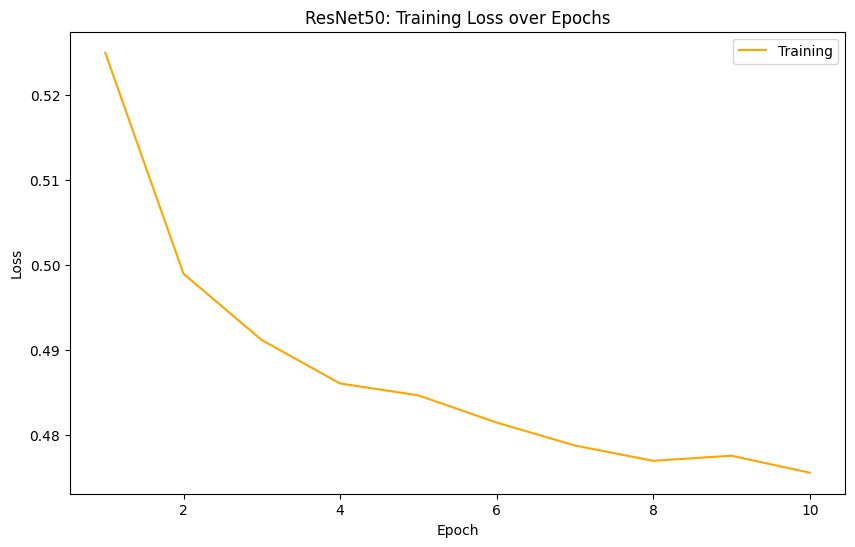

In [23]:
# Training data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loss = [0.5250, 0.4990, 0.4912, 0.4861, 0.4847, 0.4815, 0.4788, 0.4770, 0.4776, 0.4756]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, label='Training', color='orange')

# Add details
plt.title('ResNet50: Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


### Predicting on the Testing Set

In [74]:
# Define the directory of the test images
test_dir = '/content/test'

# Initialize an empty list to hold the test images
test_images = []

# Initialize an empty list to hold the image ids
image_ids = []

In [75]:
# Iterate over all the test images
for image_name in os.listdir(test_dir):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(test_dir, image_name))

    # Preprocess the image (resize to (96, 96) and normalize pixel values)
    image = cv2.resize(image, (96, 96)) / 255.0

    # Append the image to the list of test images
    test_images.append(image)

    # Remove the '.tif' extension from the image name to get the id
    image_id = image_name.split('.')[0]
    # Append the id to the list of image ids
    image_ids.append(image_id)

# Convert the list of test images to a numpy array
test_images = np.array(test_images)

In [76]:
# Use the model to make predictions on the test images
predictions = model.predict(test_images)

# Convert probabilities into class labels
predictions_labels = [1 if prob >= 0.5 else 0 for prob in predictions.flatten()]

# Create a dataframe with the image ids and the predictions
submission_df = pd.DataFrame({'id': image_ids, 'label': predictions_labels})

# Save the dataframe as a .csv file
submission_df.to_csv('Resnet_sub.csv', index=False)

1796/1796 [==============================] - 13s 7ms/step


In [77]:
submission_df.head(5)

,id,label
0,bfaece2992e4f4f1177ed841853eed35f81fdb77,0
1,297d070746a502137235a0445ece56c5163c3508,0
2,ed4cd5953ceb6532c38a49afec40680d3a36ab6f,0
3,8e1dcd31fcc5c803c6e28b67183e33d2ef8014c1,0
4,e8d5977eec4ba327a92e83ae0e8e8335d46254cc,0


In [78]:
from google.colab import files
files.download('Resnet_sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ResNet152V2 Tuned

For the second attempt, I will use a next-generation version of ResNet50 called ResNet152V2 and take a more simplified approach: adding only 2 Dense layers (relu activated) this time to see if the testing accuracy improves.

In [49]:
# Import necessary libraries
from keras.applications import ResNet152V2
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

In [50]:
# Instantiate the ResNet152V2 model with pre-trained ImageNet weights
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

234545216/234545216 [==============================] - 11s 0us/step


In [51]:
# Instantiate the Sequential model
model = Sequential()
model.add(resnet_base)  # Add the base ResNet152V2 model
model.add(Flatten())  # Flatten the output from the ResNet152V2 model

# Add additional layers
model.add(Dense(512, activation='relu'))  # Reduced from 1024 to 512 neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))  # Reduced from 512 to 256 neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Binary classification, hence 'sigmoid' activation in the final layer
model.add(Dense(1, activation='sigmoid'))

# Freeze the convolutional base
resnet_base.trainable = False

In [52]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Print a summary of the model
resnet_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 50, 50, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

In [54]:
# Fit the model on the training data
model.fit(train_generator, epochs=15)

Epoch 1/15
6876/6876 [==============================] - 599s 85ms/step - loss: 0.4222 - accuracy: 0.8111
Epoch 2/15
6876/6876 [==============================] - 588s 85ms/step - loss: 0.3870 - accuracy: 0.8298
Epoch 3/15
6876/6876 [==============================] - 587s 85ms/step - loss: 0.3770 - accuracy: 0.8355
Epoch 4/15
6876/6876 [==============================] - 589s 86ms/step - loss: 0.3691 - accuracy: 0.8392
Epoch 5/15
6876/6876 [==============================] - 590s 86ms/step - loss: 0.3632 - accuracy: 0.8427
Epoch 6/15
6876/6876 [==============================] - 591s 86ms/step - loss: 0.3609 - accuracy: 0.8432
Epoch 7/15
6876/6876 [==============================] - 590s 86ms/step - loss: 0.3556 - accuracy: 0.8464
Epoch 8/15
6876/6876 [==============================] - 591s 86ms/step - loss: 0.3548 - accuracy: 0.8456
Epoch 9/15
6876/6876 [==============================] - 591s 86ms/step - loss: 0.3506 - accuracy: 0.8485
Epoch 10/15
6876/6876 [==============================] 

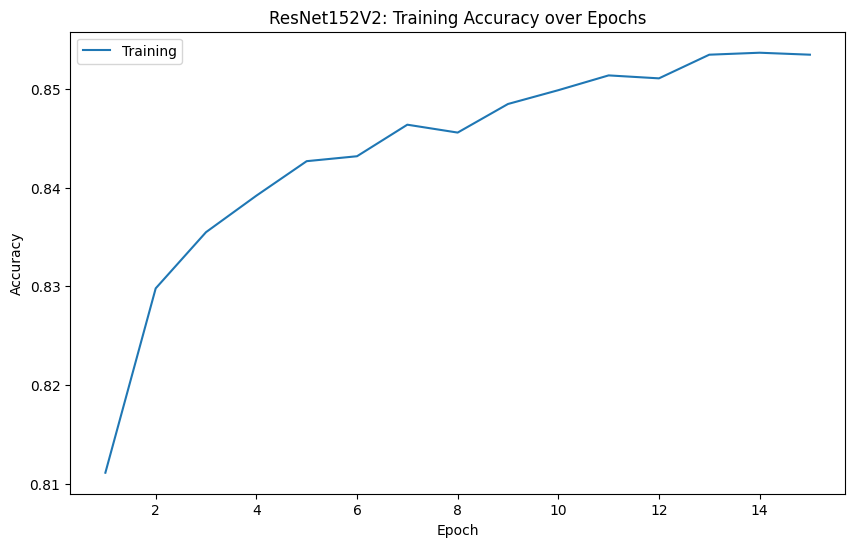

In [30]:
# Training data
epochs = list(range(1, 16))
accuracy = [0.8111, 0.8298, 0.8355, 0.8392, 0.8427, 0.8432, 0.8464, 0.8456, 0.8485, 0.8499, 0.8514, 0.8511, 0.8535, 0.8537, 0.8535]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label='Training')

# Add details
plt.title('ResNet152V2: Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


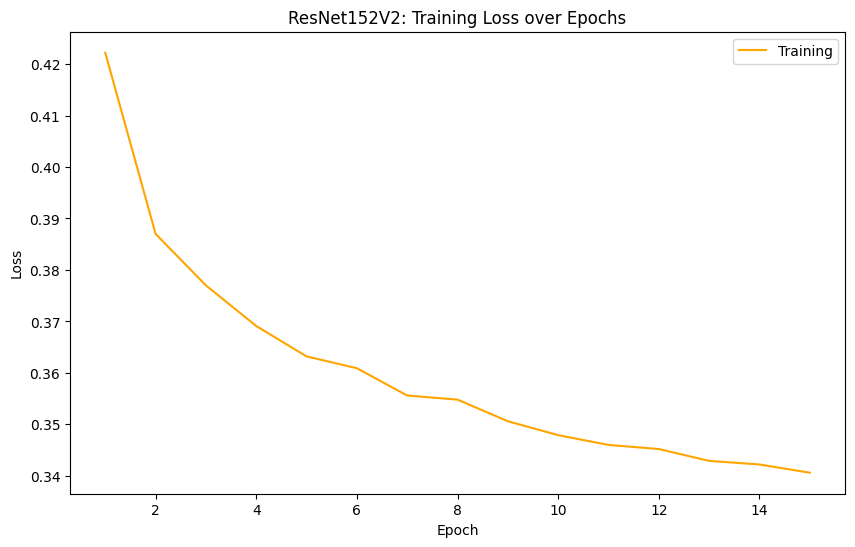

In [31]:
# Training data
epochs = list(range(1, 16))
loss = [0.4222, 0.3870, 0.3770, 0.3691, 0.3632, 0.3609, 0.3556, 0.3548, 0.3506, 0.3479, 0.3460, 0.3452, 0.3429, 0.3422, 0.3406]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, label='Training', color='orange')

# Add details
plt.title('ResNet152V2: Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

### Predicting on the Testing Set

In [55]:
# Define the directory of the test images
test_dir = '/content/test'

# Initialize an empty list to hold the test images
test_images = []

# Initialize an empty list to hold the image ids
image_ids = []

In [56]:
# Iterate over all the test images
for image_name in os.listdir(test_dir):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(test_dir, image_name))

    # Preprocess the image (resize to (96, 96) and normalize pixel values)
    image = cv2.resize(image, (96, 96)) / 255.0

    # Append the image to the list of test images
    test_images.append(image)

    # Remove the '.tif' extension from the image name to get the id
    image_id = image_name.split('.')[0]
    # Append the id to the list of image ids
    image_ids.append(image_id)

# Convert the list of test images to a numpy array
test_images = np.array(test_images)

In [57]:
# Use the model to make predictions on the test images
predictions = model.predict(test_images)

# Convert probabilities into class labels
predictions_labels = [1 if prob >= 0.5 else 0 for prob in predictions.flatten()]

# Create a dataframe with the image ids and the predictions
submission_df = pd.DataFrame({'id': image_ids, 'label': predictions_labels})

# Save the dataframe as a .csv file
submission_df.to_csv('Resnet_subTuned.csv', index=False)

1796/1796 [==============================] - 27s 14ms/step


In [58]:
submission_df.head(5)

,id,label
0,d0b88ff7a934af88bceb07999e0807ea57b4ba5e,0
1,b383b0c80ca89acd5f145734169899b8a72cb541,0
2,408023911726902a324970eb10bda47d6494d6f0,1
3,becbb0df5ac5cb2c9c43de8c172ed1a9e23f6b52,0
4,3d8c14ef259b2a66fb4661462c4eaa9be8fb9173,0


In [60]:
from google.colab import files
files.download('Resnet_subTuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DenseNet121

Next, I decided to experiment with a newer CNN architecture named DenseNet. This model works well in visual object recognition so probably it can help with our image classification project.

While it shares several similarities with the ResNet model, it diverges in certain crucial aspects. The chief difference lies in how ResNet merges the previous and subsequent layers using an addition (+) operation, whereas DenseNet accomplishes this by concatenating (.) the outputs of these layers.

DenseNet was particularly created to tackle the diminishing accuracy issue, which arises from the 'vanishing gradient' problem frequently experienced in advanced neural networks. Put simply, when the path between the input and output layer is too long, crucial information tends to get lost before it can reach its intended destination, and DenseNet is designed to mitigate this.

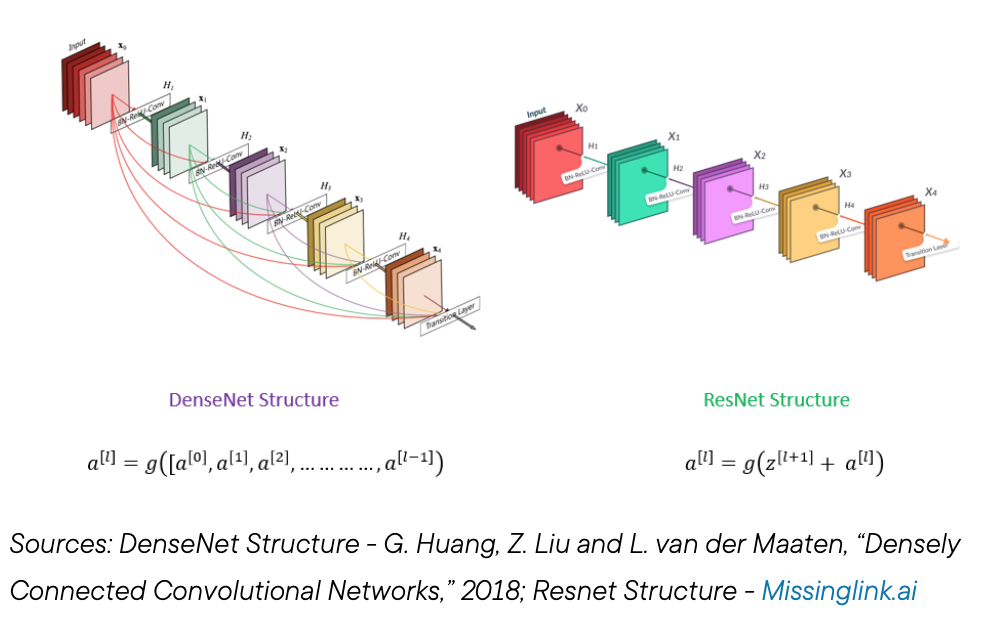

Cited: https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

I will keep this initial model very simple as below, with no additional dense layer.

In [61]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [62]:
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))   # Modified line

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

    return model

model = build_model()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,042,625
Trainable params: 6,956,929
No

In [64]:
model.fit(train_generator, epochs=13)

Epoch 1/13
6876/6876 [==============================] - 605s 86ms/step - loss: 0.2170 - accuracy: 0.9157
Epoch 2/13
6876/6876 [==============================] - 591s 86ms/step - loss: 0.1475 - accuracy: 0.9463
Epoch 3/13
6876/6876 [==============================] - 590s 86ms/step - loss: 0.1238 - accuracy: 0.9557
Epoch 4/13
6876/6876 [==============================] - 593s 86ms/step - loss: 0.1100 - accuracy: 0.9608
Epoch 5/13
6876/6876 [==============================] - 596s 87ms/step - loss: 0.1006 - accuracy: 0.9643
Epoch 6/13
6876/6876 [==============================] - 590s 86ms/step - loss: 0.0916 - accuracy: 0.9677
Epoch 7/13
6876/6876 [==============================] - 590s 86ms/step - loss: 0.0848 - accuracy: 0.9700
Epoch 8/13
6876/6876 [==============================] - 592s 86ms/step - loss: 0.0787 - accuracy: 0.9722
Epoch 9/13
6876/6876 [==============================] - 593s 86ms/step - loss: 0.0745 - accuracy: 0.9739
Epoch 10/13
6876/6876 [==============================] 

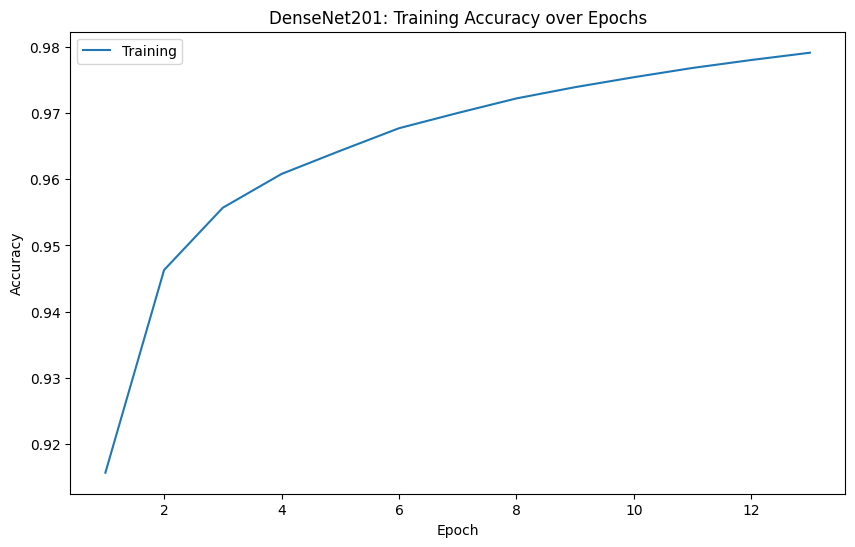

In [48]:
# Training data
epochs = list(range(1, 14))
accuracy = [0.9157, 0.9463, 0.9557, 0.9608, 0.9643, 0.9677, 0.9700, 0.9722, 0.9739, 0.9754, 0.9768, 0.9780, 0.9791]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label='Training')

# Add details
plt.title('DenseNet201: Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

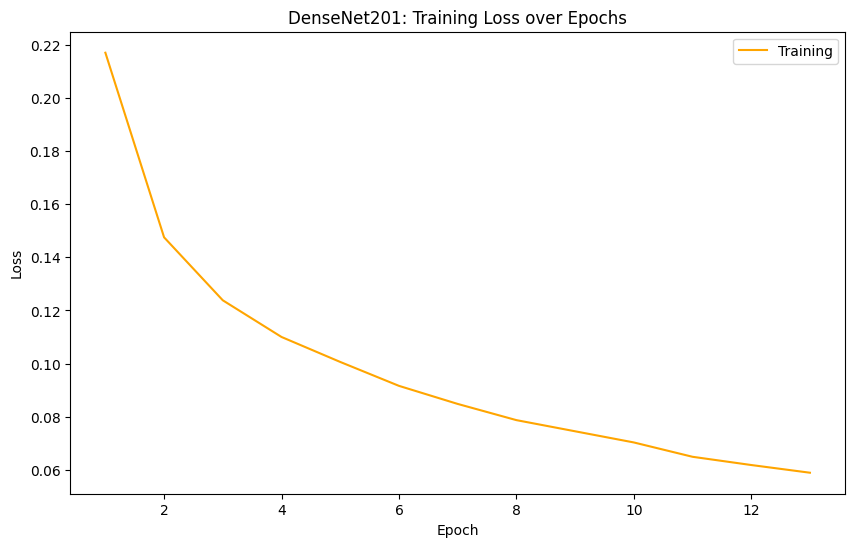

In [49]:
# Training data
epochs = list(range(1, 14))
loss = [0.2170, 0.1475, 0.1238, 0.1100, 0.1006, 0.0916, 0.0848, 0.0787, 0.0745, 0.0703, 0.0649, 0.0618, 0.0589]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, label='Training', color='orange')

# Add details
plt.title('DenseNet201: Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


### Predicting on the Testing Set

In [65]:
# Define the directory of the test images
test_dir = '/content/test'

# Initialize an empty list to hold the test images
test_images = []

# Initialize an empty list to hold the image ids
image_ids = []

In [66]:
# Iterate over all the test images
for image_name in os.listdir(test_dir):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(test_dir, image_name))

    # Preprocess the image (resize to (96, 96) and normalize pixel values)
    image = cv2.resize(image, (96, 96)) / 255.0

    # Append the image to the list of test images
    test_images.append(image)

    # Remove the '.tif' extension from the image name to get the id
    image_id = image_name.split('.')[0]
    # Append the id to the list of image ids
    image_ids.append(image_id)

# Convert the list of test images to a numpy array
test_images = np.array(test_images)

In [67]:
# Use the model to make predictions on the test images
predictions = model.predict(test_images)

# Convert probabilities into class labels
predictions_labels = [1 if prob >= 0.5 else 0 for prob in predictions.flatten()]

# Create a dataframe with the image ids and the predictions
submission_df = pd.DataFrame({'id': image_ids, 'label': predictions_labels})

# Save the dataframe as a .csv file
submission_df.to_csv('DenseNet121final.csv', index=False)

1796/1796 [==============================] - 23s 12ms/step


In [68]:
submission_df.head(5)

,id,label
0,d0b88ff7a934af88bceb07999e0807ea57b4ba5e,0
1,b383b0c80ca89acd5f145734169899b8a72cb541,0
2,408023911726902a324970eb10bda47d6494d6f0,0
3,becbb0df5ac5cb2c9c43de8c172ed1a9e23f6b52,0
4,3d8c14ef259b2a66fb4661462c4eaa9be8fb9173,0


In [69]:
from google.colab import files
files.download('DenseNet121final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DenseNet121 Tuned

### Model Training

For tuning of the DenseNet121, I would like to add 2 dense layers with accompanying dropouts to see if the testing accuracy improves.

In [79]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained ImageNet weights
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Define the additional layers to be added to the base
x = densenet_base.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
x = Dense(512, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Final sigmoid layer for binary classification

# Combine the base and the additional layers into a single model
model = Model(inputs=densenet_base.input, outputs=predictions)

# Freeze the layers of the base model
for layer in densenet_base.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_concat (Concatena  (None, 12, 12, 192)  0          ['conv3_block1_concat[0][0]',    
 te)                                                              'conv3_block2_2_conv[0][0]']    
                                                                                                  
 conv3_blo

In [80]:
# Fit the model on the training data
model.fit(train_generator, epochs=10)

Epoch 1/10
6876/6876 [==============================] - 594s 86ms/step - loss: 0.3797 - accuracy: 0.8320
Epoch 2/10
6876/6876 [==============================] - 586s 85ms/step - loss: 0.3311 - accuracy: 0.8566
Epoch 3/10
6876/6876 [==============================] - 586s 85ms/step - loss: 0.3178 - accuracy: 0.8636
Epoch 4/10
6876/6876 [==============================] - 586s 85ms/step - loss: 0.3072 - accuracy: 0.8684
Epoch 5/10
6876/6876 [==============================] - 589s 86ms/step - loss: 0.3007 - accuracy: 0.8725
Epoch 6/10
6876/6876 [==============================] - 587s 85ms/step - loss: 0.2950 - accuracy: 0.8755
Epoch 7/10
6876/6876 [==============================] - 586s 85ms/step - loss: 0.2906 - accuracy: 0.8773
Epoch 8/10
6876/6876 [==============================] - 588s 85ms/step - loss: 0.2872 - accuracy: 0.8783
Epoch 9/10
6876/6876 [==============================] - 590s 86ms/step - loss: 0.2844 - accuracy: 0.8809
Epoch 10/10
6876/6876 [==============================] 

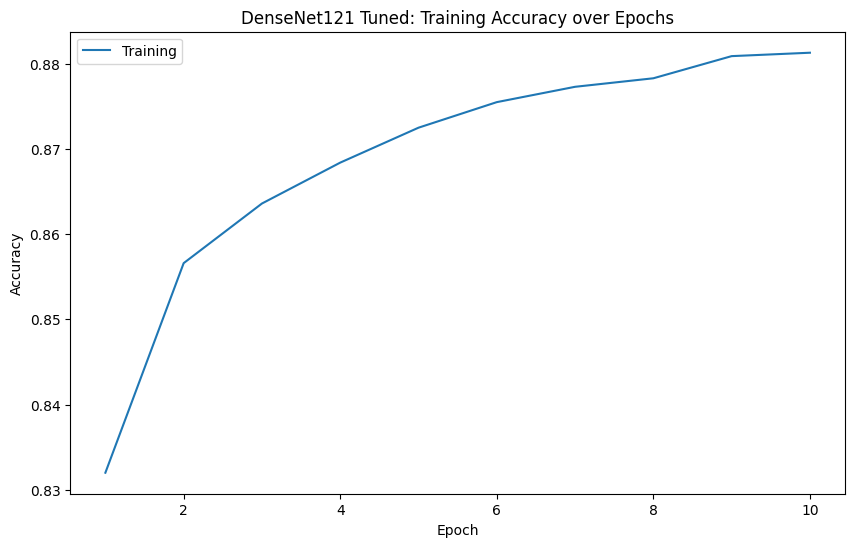

In [47]:
# Training data
epochs = list(range(1, 11))
accuracy = [0.8320, 0.8566, 0.8636, 0.8684, 0.8725, 0.8755, 0.8773, 0.8783, 0.8809, 0.8813]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label='Training')

# Add details
plt.title('DenseNet121 Tuned: Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

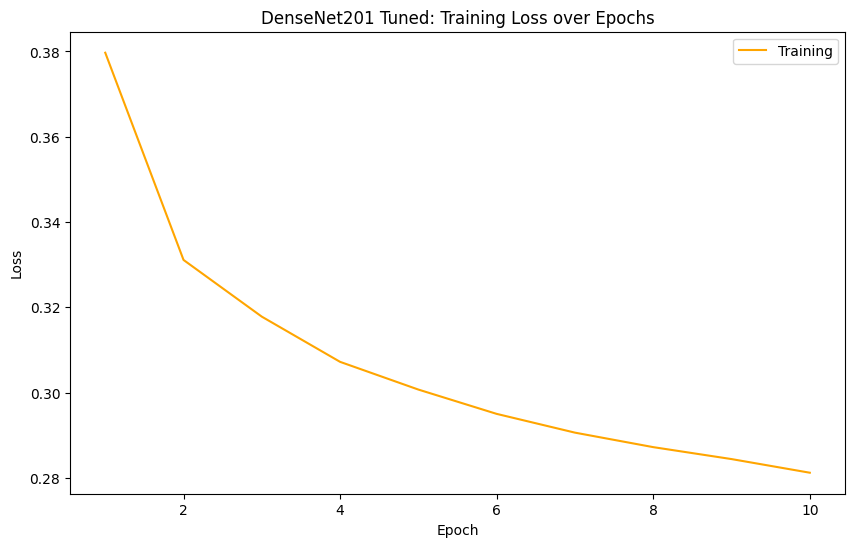

In [50]:
# Training data
epochs = list(range(1, 11))
loss = [0.3797, 0.3311, 0.3178, 0.3072, 0.3007, 0.2950, 0.2906, 0.2872, 0.2844, 0.2812]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, label='Training', color='orange')

# Add details
plt.title('DenseNet201 Tuned: Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

### Predicting on the Testing Set

In [81]:
# Define the directory of the test images
test_dir = '/content/test'

# Initialize an empty list to hold the test images
test_images = []

# Initialize an empty list to hold the image ids
image_ids = []

In [82]:
# Iterate over all the test images
for image_name in os.listdir(test_dir):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(test_dir, image_name))

    # Preprocess the image (resize to (96, 96) and normalize pixel values)
    image = cv2.resize(image, (96, 96)) / 255.0

    # Append the image to the list of test images
    test_images.append(image)

    # Remove the '.tif' extension from the image name to get the id
    image_id = image_name.split('.')[0]
    # Append the id to the list of image ids
    image_ids.append(image_id)

# Convert the list of test images to a numpy array
test_images = np.array(test_images)

In [83]:
# Use the model to make predictions on the test images
predictions = model.predict(test_images)

# Convert probabilities into class labels
predictions_labels = [1 if prob >= 0.5 else 0 for prob in predictions.flatten()]

# Create a dataframe with the image ids and the predictions
submission_df = pd.DataFrame({'id': image_ids, 'label': predictions_labels})

# Save the dataframe as a .csv file
submission_df.to_csv('DenseNet_sub.csv', index=False)

1796/1796 [==============================] - 24s 12ms/step


In [84]:
submission_df.head(5)

,id,label
0,bfaece2992e4f4f1177ed841853eed35f81fdb77,1
1,297d070746a502137235a0445ece56c5163c3508,1
2,ed4cd5953ceb6532c38a49afec40680d3a36ab6f,1
3,8e1dcd31fcc5c803c6e28b67183e33d2ef8014c1,0
4,e8d5977eec4ba327a92e83ae0e8e8335d46254cc,1


In [85]:
from google.colab import files
files.download('DenseNet_sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results and Conclusion

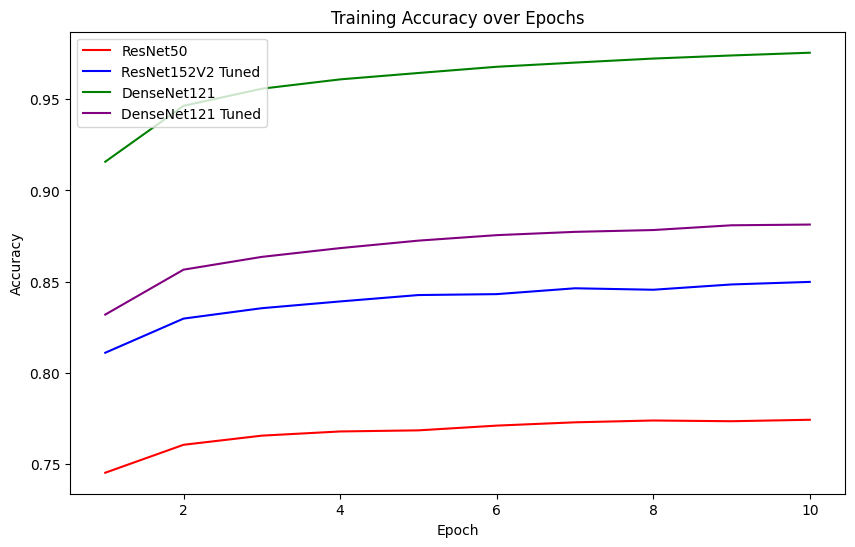

In [44]:
# Epochs
epochs = list(range(1, 11))

# Accuracy data from all four trainings
accuracy_1 = [0.7454, 0.7607, 0.7657, 0.7680, 0.7686, 0.7712, 0.7730, 0.7740, 0.7736, 0.7744]
accuracy_2 = [0.8111, 0.8298, 0.8355, 0.8392, 0.8427, 0.8432, 0.8464, 0.8456, 0.8485, 0.8499]
accuracy_3 = [0.9157, 0.9463, 0.9557, 0.9608, 0.9643, 0.9677, 0.9700, 0.9722, 0.9739, 0.9754]
accuracy_4 = [0.8320, 0.8566, 0.8636, 0.8684, 0.8725, 0.8755, 0.8773, 0.8783, 0.8809, 0.8813]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy_1, label='ResNet50', color='red')
plt.plot(epochs, accuracy_2, label='ResNet152V2 Tuned', color='blue')
plt.plot(epochs, accuracy_3, label='DenseNet121', color='green')
plt.plot(epochs, accuracy_4, label='DenseNet121 Tuned', color='purple')

# Add details
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


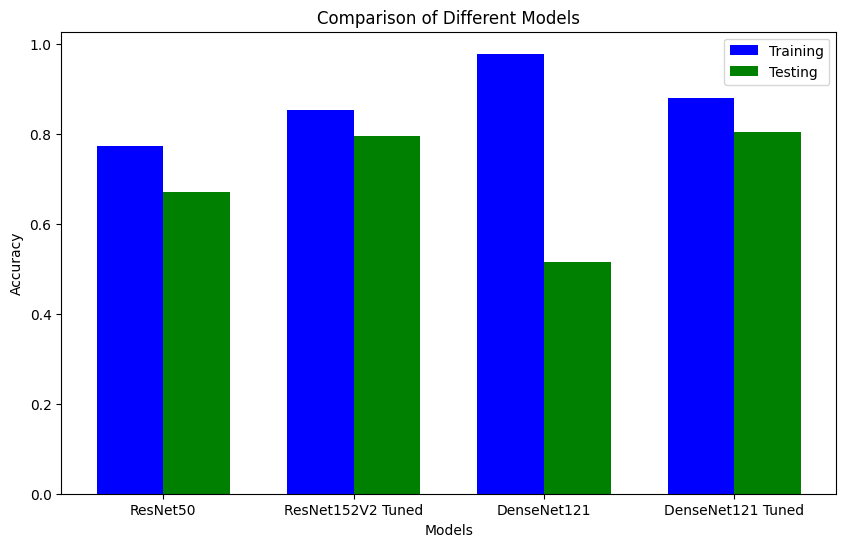

In [46]:
import numpy as np

# Define data
models = ['ResNet50', 'ResNet152V2 Tuned', 'DenseNet121', 'DenseNet121 Tuned']
training_accuracy = [0.7744, 0.8535, 0.9791, 0.8813]
testing_accuracy = [0.6705, 0.7964, 0.5156, 0.8052]

# Define bar width
bar_width = 0.35

# Create index
index = np.arange(len(models))

# Create plot
plt.figure(figsize=(10,6))

bar1 = plt.bar(index, training_accuracy, bar_width, label='Training', color='b')
bar2 = plt.bar(index + bar_width, testing_accuracy, bar_width, label='Testing', color='g')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Different Models')
plt.xticks(index + bar_width / 2, models)  # position x-axis labels in the center of the bars
plt.legend()

# Show plot
plt.show()


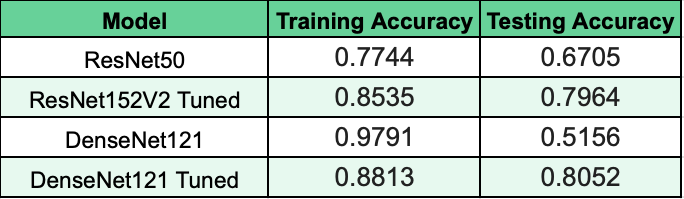

The results are quite interesting. We can see how DenseNet121 was overfitted at first with the extremely high training accuracy at almost 0.98, only to score very poorly on the testing set: at less than 52% accurate. On the other hand, ResNet50 could be considered as an underfitted model with training accuracy at only 0.77 and consequently the testing accuracy at 0.67. After some tweaking, ResNet152V2 Tuned model's training accuracy increased to over 85% and testing accuracy increased to almost 80%. Similarly, while the DenseNet121 Tuned model's training accuracy dropped to 88%, its testing accuracy was drastically improved to over 80% as well.

In the case of DenseNet, adding additional Dense layers actually helped with increasing the testing accuracy. While on the other hand, decreasing the number of Dense layers and using a newer version of ResNet facilitated better testing results.

At 80% accurate on the Testing set, this result is considered inferior compared to many 90% plus results on Kaggle. However, given the constrained in resources this result is acceptable. Future research should be spent on further tuning the hyperparameters not limited to extending the number of epochs, changing batch size, new image preprocessing methods, dense and final activation function, choosing optimizer,...